###  What was the best month for sales? How much was earned that month?

##### Import necessary libraries

In [281]:
import pandas as pd
import os
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

##### Merging 12 files of sales data into a single file

In [105]:
directory = 'C:/Users/vitiu/Desktop/Sales Product Data/Raw Data'
output_file = 'C:/Users/vitiu/Desktop/Sales Product Data/2019_sales_data.csv'
files = os.listdir(directory)

In [108]:
# Create an output CSV file
with open(output_file, 'w', newline='') as outfile:
    writer = csv.writer(outfile)

    # Iterate over the files
    for file in files:
        file_path = os.path.join(directory, file)

        # Check if the current item is a file
        if os.path.isfile(file_path):
            # Open the file and read its contents
            with open(file_path, 'r') as infile:
                reader = csv.reader(infile)
                # Write each row from the input file to the output CSV file
                for row in reader:
                    writer.writerow(row)

print("Files merged into", output_file)

Files merged into C:/Users/vitiu/Desktop/Sales Product Data/2019_sales_data.csv


##### Read in updated dataframe

In [109]:
sales_data = pd.read_csv('C:/Users/vitiu/Desktop/Sales Product Data/2019_sales_data.csv')

##### Drop empty rows

In [110]:
sales_data.dropna(inplace=True)

##### Convert the variables to appropriate data types

In [111]:
sales_data['Order Date'] = pd.to_datetime(sales_data['Order Date'], errors='coerce')
sales_data['Quantity Ordered'] = pd.to_numeric(sales_data['Quantity Ordered'], errors='coerce')
sales_data['Price Each'] = pd.to_numeric(sales_data['Price Each'], errors='coerce')

##### Drop rows with invalid 'Order Date' values

In [112]:
sales_data = sales_data.dropna(subset=['Order Date'])

##### Extract the month and total earnings columns

In [113]:
sales_data['Month'] = sales_data['Order Date'].dt.month
sales_data['Earnings'] = sales_data['Quantity Ordered'] * sales_data['Price Each']

##### Group the data by month and calculate the total earnings

In [114]:
monthly_earnings = sales_data.groupby('Month')['Earnings'].sum()

#### Determine the best month for sales and the corresponding earnings

In [115]:
best_month = monthly_earnings.idxmax()
earnings_in_best_month = monthly_earnings.max()

#### Plotting the monthly earnings

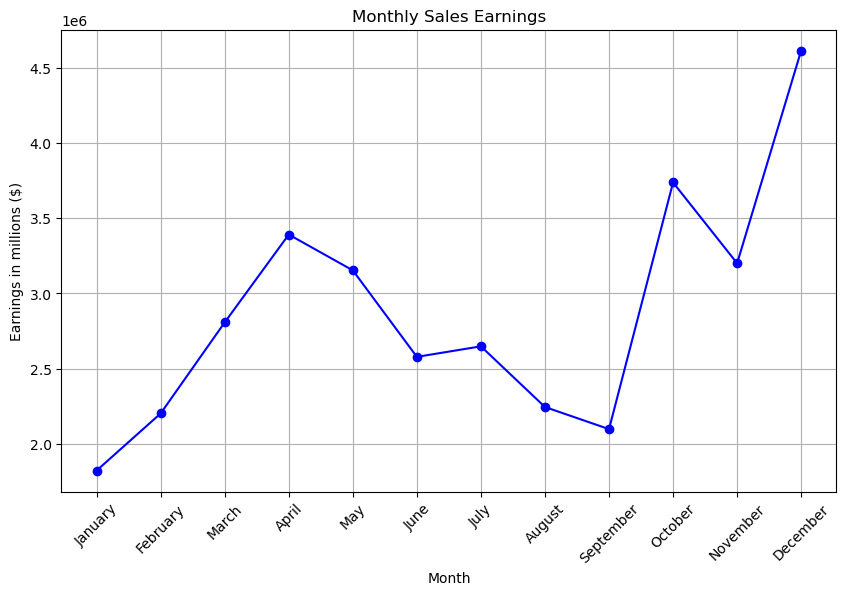

In [123]:
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
plt.figure(figsize=(10, 6))
plt.plot(months, monthly_earnings, marker='o', linestyle='-', color='blue')
plt.xlabel('Month')
plt.ylabel('Earnings in millions ($)')
plt.title('Monthly Sales Earnings')
plt.xticks(rotation=45)
plt.grid(True)
plt.savefig('C:/Users/vitiu/Desktop/Sales Product Data/monthly_sales.png')

### What City had the highest number of sales?

##### Extract city and state from the Purchase Address column

In [255]:
sales_data['City'] = sales_data['Purchase Address'].apply(lambda x: x.split(',')[1].strip() + ', ' + x.split(',')[2].strip().split(' ')[0])

##### Calculate the number of sales for each city

In [256]:
city_sales = sales_data.groupby('City').size().reset_index(name='Total Sales')

##### Calculate the number of revenue it generated

In [257]:
sales_data['Revenue'] = sales_data['Quantity Ordered'] * sales_data['Price Each']
city_revenue = sales_data.groupby('City')['Revenue'].sum().reset_index(name='Total Revenue')

##### Get the city with the highest number of sales

In [258]:
best_sales_city = city_sales.loc[city_sales['Total Sales'].idxmax()]

##### Find the City with the highest total revenue

In [259]:
best_revenue_city = city_revenue.loc[city_revenue['Total Revenue'].idxmax()]

##### Display the result

In [264]:
print("Best City for Sales:")
print("City (by Sales):", best_sales_city['City'])
print("Total Sales:", best_sales_city['Total Sales'])
print()
print("Best City for Revenue:")
print("City (by Revenue):", best_revenue_city['City'])
print("Total Revenue:", best_revenue_city['Total Revenue'])

Best City for Sales:
City (by Sales): San Francisco, CA
Total Sales: 44732

Best City for Revenue:
City (by Revenue): San Francisco, CA
Total Revenue: 8262203.91


##### Sort the city_sales DataFrame by Total Sales in descending order

In [265]:
city_sales_sorted = city_sales.sort_values(by='Total Sales', ascending=False)

##### Select the top 10 cities

In [266]:
top_cities = city_sales_sorted.head(10)

##### Plot the bar chart

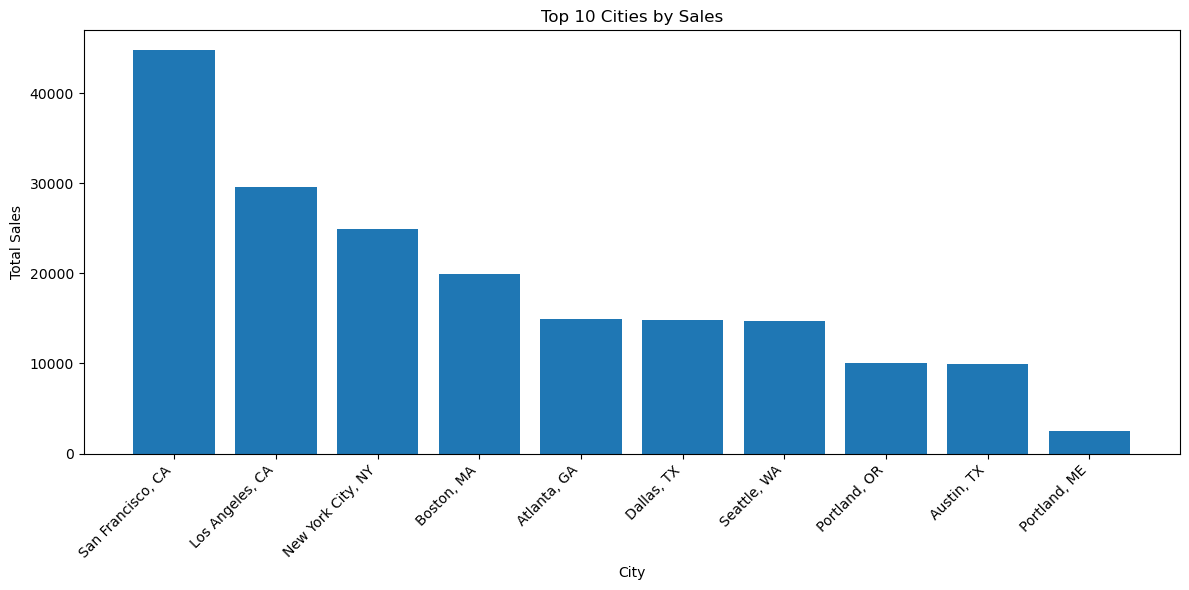

In [267]:
plt.figure(figsize=(12, 6))
plt.bar(top_cities['City'], top_cities['Total Sales'])
plt.xlabel('City')
plt.ylabel('Total Sales')
plt.title('Top 10 Cities by Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('C:/Users/vitiu/Desktop/Sales Product Data/city_sales.png')

### What time should we display adverstisement to maximize likelihood of customer's buying product?

##### Convert 'Order Date' column to datetime format

In [274]:
sales_data['Order Time'] = pd.to_datetime(sales_data['Order Date'])

##### Create a pivot table with order frequencies

In [275]:
order_pivot = sales_data.pivot_table(index=sales_data['Order Time'].dt.hour, columns=sales_data['Order Time'].dt.dayofweek, aggfunc='size', fill_value=0)

##### Define custom tick labels for the days of the week

In [278]:
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

##### Create a heatmap of order frequencies

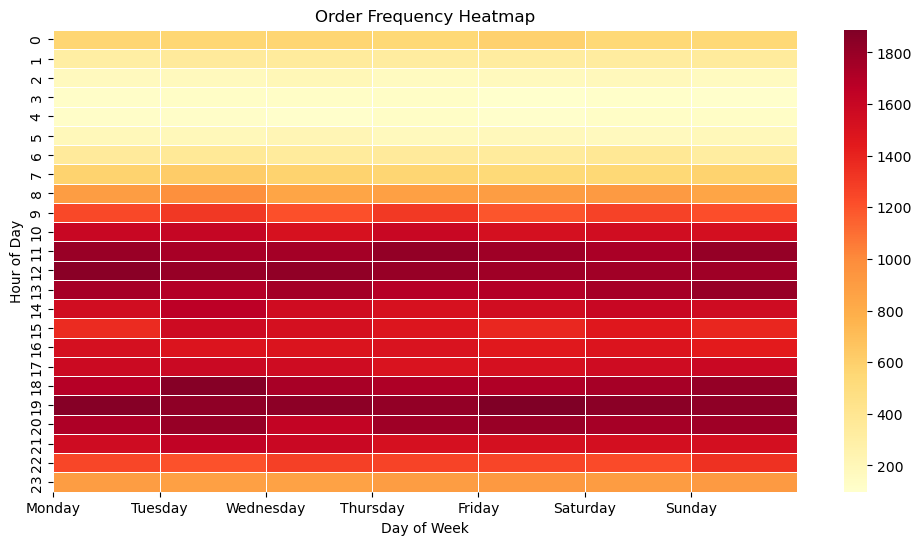

In [280]:
plt.figure(figsize=(12, 6))
sns.heatmap(order_pivot, cmap='YlOrRd', linewidths=0.5)
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.title('Order Frequency Heatmap')
plt.xticks(range(len(day_labels)), day_labels)
plt.savefig('C:/Users/vitiu/Desktop/Sales Product Data/order_frequency_heatmap.png')

### What products are most often sold together?

##### Preprocess the data

In [282]:
order_data = sales_data[['Order ID', 'Product']]

###### Group the data by order ID and create a list of products for each order

In [283]:
grouped_orders = order_data.groupby('Order ID')['Product'].apply(list)

##### Find product combinations

In [291]:
combinations_list = []
for products in grouped_orders:
    # Generate all possible combinations of products in the order
    product_combinations = list(combinations(products, 2))  # Change the '2' to get different combinations (e.g., 3 for triplets)
    combinations_list.extend(product_combinations)

##### Count the combinations

In [289]:
combination_counts = Counter(combinations_list)

##### Get the most common product combinations

In [290]:
top_combinations = combination_counts.most_common(10)  # Adjust the number to get more or fewer top combinations

##### Print the top combinations

In [287]:
for combination, count in top_combinations:
    print(f"Combination: {', '.join(combination)} \t Count: {count}")

Combination: iPhone, Lightning Charging Cable 	 Count: 1005
Combination: Google Phone, USB-C Charging Cable 	 Count: 987
Combination: iPhone, Wired Headphones 	 Count: 447
Combination: Google Phone, Wired Headphones 	 Count: 414
Combination: Vareebadd Phone, USB-C Charging Cable 	 Count: 361
Combination: iPhone, Apple Airpods Headphones 	 Count: 360
Combination: Google Phone, Bose SoundSport Headphones 	 Count: 220
Combination: USB-C Charging Cable, Wired Headphones 	 Count: 160
Combination: Vareebadd Phone, Wired Headphones 	 Count: 143
Combination: Lightning Charging Cable, Wired Headphones 	 Count: 92


### What product sold the most?

##### Group the data by product and calculate the total quantity sold

In [292]:
product_sales = sales_data.groupby('Product')['Quantity Ordered'].sum().reset_index()

##### Sort the products by total quantity sold in descending order

In [293]:
product_sales = product_sales.sort_values(by='Quantity Ordered', ascending=False)

##### Get the product with the highest sales

In [294]:
top_product = product_sales.iloc[0]['Product']
total_sales = product_sales.iloc[0]['Quantity Ordered']

##### Print the top product and its total sales

In [295]:
print(f"The product that sold the most is {top_product} with a total of {total_sales} units sold.")

The product that sold the most is AAA Batteries (4-pack) with a total of 31017.0 units sold.


##### Visualize the sales data

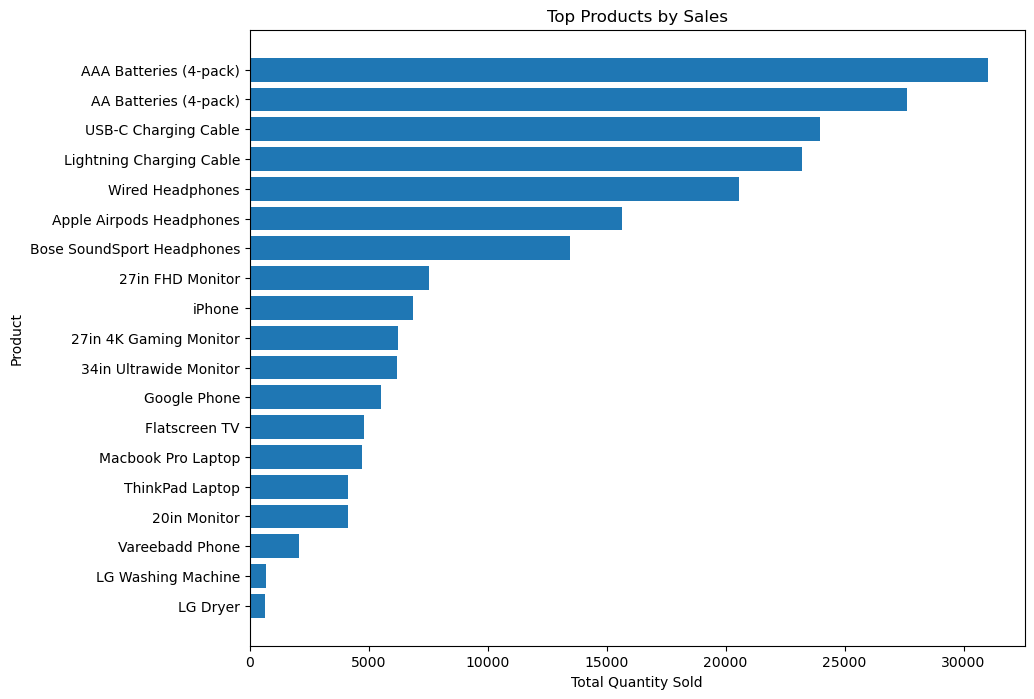

In [302]:
plt.figure(figsize=(10, 8))
plt.barh(product_sales['Product'], product_sales['Quantity Ordered'])
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product')
plt.title('Top Products by Sales')
plt.gca().invert_yaxis()
plt.savefig('C:/Users/vitiu/Desktop/Sales Product Data/top_products.png', dpi=300, bbox_inches='tight')

### How much probability for next people will order USB-C Charging Cable?

##### Count the total number of orders

In [303]:
total_orders = len(sales_data)

##### Count the number of orders that include the USB-C Charging Cable

In [304]:
usb_c_orders = len(sales_data[sales_data['Product'] == 'USB-C Charging Cable'])

##### Calculate the probability

In [307]:
probability_percentage = (usb_c_orders / total_orders) * 100

print('Probability of ordering USB-C Charging Cable: {:.2f}%'.format(probability_percentage))

Probability of ordering USB-C Charging Cable: 11.78%


### How much probability for next people will order iPhone?

##### Count the number of iPhone orders

In [308]:
iphone_orders = len(sales_data[sales_data['Product'] == 'iPhone'])

##### Calculate the probability as a percentage

In [310]:
probability = (iphone_orders / total_orders) * 100
print('Probability of ordering an iPhone: {:.2f}%'.format(probability))

Probability of ordering an iPhone: 3.68%


### How much probability for next people will order Google Phone?

##### Count the number of Google Phone orders

In [311]:
google_phone_orders = len(sales_data[sales_data['Product'] == 'Google Phone'])

##### Calculate the probability as a percentage

In [313]:
probability = (google_phone_orders / total_orders) * 100
print('Probability of ordering a Google Phone: {:.2f}%'.format(probability))

Probability of ordering a Google Phone: 2.97%


### How much probability other peoples will order Wired Headphones?

##### Count the number of Wired Headphones orders

In [314]:
wired_headphones_orders = len(sales_data[sales_data['Product'] == 'Wired Headphones'])

##### Calculate the probability as a percentage

In [315]:
probability = (wired_headphones_orders / total_orders) * 100
print('Probability of ordering Wired Headphones: {:.2f}%'.format(probability))

Probability of ordering Wired Headphones: 10.15%
